---
layout: page
title: Método Científico (Incompleto)
nav_order: 12
---

[<img src="./colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/icd-ufmg/icd-ufmg.github.io/blob/master/_lessons/12-causalidade.ipynb)


# Método Científico (Incompleto)
{: .no_toc .mb-2 }

Juntando o método científico com o conceito de causalidade
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Entender como testes de hipótese ligam com causalidade
1. Entender o método científico

---
**Sumário**
1. TOC
{:toc}
---

In [1]:
# -*- coding: utf8

from scipy import stats as ss

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.style.use('seaborn-colorblind')

plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [3]:
plt.ion()

In [4]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

## Introdução

Aqui, vamos brincar um pouco com dados onde posso falar algo de causalidade. Isto é, foi feito um experimento controlado e randomizado. Note que minha ferramenta é a mesma de antes, permutação, porém a forma que os dados foram coletados mudara. Esta é a diferença.

Abaixo tenho uma função simples que permuta uma coluna de um dataframe. Vamos usar ela para implementar o nosso teste de permutação. Este exemplo é bem similar ao teste de permutação já feito. Use o mesmo para revisar!

In [5]:
def permuta(df, coluna):
    '''
    Permuta um dataframe com base e uma coluna categórica.
    Este código é mais lento pois cria uma cópia.
    
    Parâmetros
    ----------
    df: o dataframe
    coluna: uma coluna categórica
    
    Retorna
    -------
    um novo df permutado
    '''
    
    novo = df.copy()            # Cópia dos dados
    dados = df[coluna].copy()   # Copia da coluna, evitar um warning pandas. Deve ter forma melhor de fazer.
    np.random.shuffle(dados)    # Faz o shuffle
    novo[coluna] = dados        # Faz overwrite da coluna
    return novo

## Dados

O DataFrame consiste de dois grupos. Um de controle, outro de tratamento. No primeiro, foi medicado placebo. No segundo, foi utilizado um novo medicamento. Quando o resultado é 1, dizemos que houve melhoria nos pacientes.

In [6]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/13-CausalidadeRCT/bta.csv')
df.head()

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0


In [7]:
control = df.query('Group == "Control"')
control.head()

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0


In [8]:
medicados = df.query('Group != "Control"')
medicados.head()

,Group,Result
16,Treatment,1.0
17,Treatment,1.0
18,Treatment,1.0
19,Treatment,1.0
20,Treatment,1.0


Ao somar o resultado de cada caso, vejo quantos melhoraram. Note que o valor é bem maior nos medicados.

In [9]:
control['Result'].sum()

2.0

In [10]:
medicados['Result'].sum()

9.0

Como os dados são 1/0, a média aqui vira uma proporção. Cada observação, $x_i \in \{0, 1\}$. 0 é quando não temos um efeito positivo e 1 quando temos.

$$\sum_{i=1}^{N} x_i/n$$

In [11]:
control['Result'].mean()

0.125

In [12]:
medicados['Result'].mean()

0.6

Aqui tenho o efeito nos dados reais, mensurados em abs.

In [13]:
abs(medicados['Result'].mean() - control['Result'].mean())

0.475

In [14]:
tobs = abs(medicados['Result'].mean() - control['Result'].mean())

In [15]:
tobs

0.475

## Dados permutados

In [16]:
p1 = permuta(df, 'Group')
p1.head()

,Group,Result
0,Treatment,1.0
1,Control,1.0
2,Control,0.0
3,Treatment,0.0
4,Control,0.0


In [17]:
p1.query('Group == "Control"').mean()

Result    0.25
dtype: float64

In [18]:
p1.query('Group == "Treatment"').mean()

Result    0.466667
dtype: float64

In [19]:
df.head()

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0


## Teste de Permutação abaixo.

In [20]:
valores = []
for _ in range(10000):
    novo = permuta(df, 'Group')
    controle = novo.query('Group == "Control"')['Result']
    medicados = novo.query('Group != "Control"')['Result']
    valores.append(abs(controle.mean() - medicados.mean()))

In [21]:
valores = np.array(valores)

In [22]:
valores

array([0.04166667, 0.04166667, 0.3       , ..., 0.04166667, 0.0875    ,
       0.04166667])

[0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7 ]


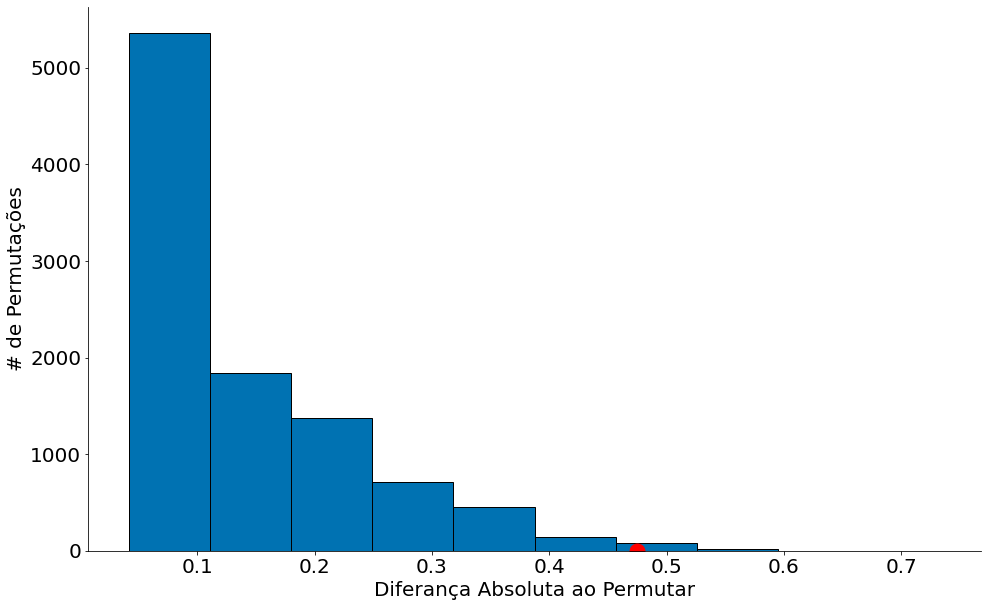

In [23]:
bins = np.arange(0.15, 0.75, 0.05)
print(bins)
plt.hist(valores, bins=10, edgecolor='k')
plt.ylabel('# de Permutações')
plt.xlabel('Diferança Absoluta ao Permutar')
plt.plot([tobs], [0], 'ro', ms=15)
despine()

In [24]:
valor_p = (valores > tobs).mean()
valor_p

0.0024

## Diferença de outros exemplos

Neste exemplo foi feito uma intervenção. Isto é, medicamos parte dos dados. Não estamos observando dados apenas. Por isto um exemplo como este é causal, vemos um efeito real em um experimento controlado! Mais importante do que isto, em 2011 foi averiguado que este pequeno estudo é um dos mais corretos quando se trata de dor crônica lombar! O ferramental aqui foram testes simples + uma boa amostra! 